# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

First, I'll look at the inferred datatypes.

In [3]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [5]:
azdias.select_dtypes(include=object).nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               5162
OST_WEST_KZ                    2
dtype: int64

Ok, let's work on the object data types first. After digging through the descriptions and, where necessary, directly inspecting the column, here are the descriptions and my initial recommended course of action:
  - CAMEO_DEU_2015: detailed classification --> convert to categorical
  - CAMEO_DEUG_2015: income group --> convert to ordinal (1 is upper class, 9 is urban working class, -1 is unknown)
  - CAMEO_INTL_2015: international classification --> not described, contains nans and odd category 'XX', more investigation required
  - D19_LETZTER_KAUF_BRANCHE: not described, translation is "last purchase industry", looks like it is the titles for the other D19 columns
  - EINGEFUEGT_AM: not described, translation is "inserted on" --> these are dates, should convert to datetime
  - OST_WEST_KZ: flag indicating former east (O) or west (W) germany, unknown is -1. --> convert to categorical
  - PRODUCT_GROUP: (only present in CUSTOMER data) not described, contains three groups: FOOD, COSMETIC, COSMETIC AND FOOD --> convert to categorical
  - CUSTOMER_GROUP: (only present in CUSTOMER data) not described, contains either MULTI_BUYER or SINGLE_BUYER --> convert to categorical
  
Now, let's make a little class to convert these data types and structure it for later use in a pipeline. The PRODUCT_GROUP, ONLINE_PURCHASE, and CUSTOMER_GROUP columns will be dropped since these are not available in the population dataset. 

In [6]:
def object_dtype(df, columns):
    for col in columns:
        if col in ['CAMEO_DEU_2015', 'CAMEO_INTL_2015', 
                   'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ',
                   'CAMEO_DEUG_2015']:
            df[col] = df[col].astype('category')
        if col == 'EINGEFUEGT_AM':
            df[col] = pd.to_datetime(df[col], infer_datetime_format=True)
        if col in ['PRODUCT_GROUP', 'CUSTOMER_GROUP'] and col in df.columns:
            df = df.drop([col], axis=1)
        if 'ONLINE_PURCHASE' in df.columns:
            df = df.drop(['ONLINE_PURCHASE'], axis=1)
    return df
        
            

class ObjectDtype(BaseEstimator, TransformerMixin):
    def __init__(self, include='all'):
        self.include = include
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.include == 'all':
            columns = ['CAMEO_DEU_2015', 'CAMEO_INTL_2105', 
                   'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ',
                   'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'EINGEFUEGT_AM',
                   'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
        else:
            columns = self.include    
        return object_dtype(X, columns)
            

Next, I'll check out the columns with integer datatypes to see if they should be categorical. If there are only a few unique values then it is probably safe (at this point anyway) to assume that the column represents categorical data that has already been encoded. I'll pay more attention to the fields with a large number of unique values.

In [7]:
print(azdias.select_dtypes(include=int).nunique().sort_values(ascending=False)[:5])
print(customers.select_dtypes(include=int).nunique().sort_values(ascending=False)[:5])

LNR                      891221
GEBURTSJAHR                 117
PRAEGENDE_JUGENDJAHRE        16
D19_GESAMT_DATUM             10
D19_VERSAND_DATUM            10
dtype: int64
LNR                          191652
GEBURTSJAHR                     113
PRAEGENDE_JUGENDJAHRE            16
D19_GESAMT_DATUM                 10
D19_VERSAND_OFFLINE_DATUM        10
dtype: int64


In [8]:
print(azdias['LNR'].head(10))
print(len(azdias['LNR']))

0    910215
1    910220
2    910225
3    910226
4    910241
5    910244
6    910248
7    910261
8    645145
9    645153
Name: LNR, dtype: int64
891221


LNR is not in the desciption file, however, the number of unuique entries is identical to the number of entries so it is likely a customer identification number.

GEBURTSJAHR is the year of birth. There are quite of few entries with a value of zero. 

In [9]:
print(azdias['GEBURTSJAHR'].value_counts().sort_values(ascending=False)[[0]])
print(customers['GEBURTSJAHR'].value_counts().sort_values(ascending=False)[[0]])

0    392318
Name: GEBURTSJAHR, dtype: int64
0    93024
Name: GEBURTSJAHR, dtype: int64


As seen above, there are 93024 enties in the customer data without a birth year. It will probably be a good idea to keep these either as zero or use and imputation strategy and append an additional column indicating if the birth year is known. I'll develope another class to drop the LNR column and provide an imputation method for the birth year.

In [10]:
class DropAndImputeBirthYear(BaseEstimator, TransformerMixin):
    def __init__(self, drop=True, impute=None, add_column=True):
        self.drop = drop
        self.impute = impute
        self.add_column = add_column
        
    def fit(self, X, y=None):
        if self.impute is not None:
            self.imputer = Imputer(missing_values=0, strategy=self.impute)
            self.imputer.fit(X[['GEBURTSJAHR']], y)
        return self
        
    def transform(self, X):
        if self.add_column:
            X['has_birth_year'] = (X['GEBURTSJAHR'] > 0).astype('category')
        if self.impute is not None:
            X['GEBURTSJAHR_imputed'] = self.imputer.transform(X[['GEBURTSJAHR']])
        if self.drop:
            X = X.drop(['LNR', 'GEBURTSJAHR'], axis=1)
        return X

In [11]:
data_pipe = Pipeline([('cat', ObjectDtype()),
                      ('drop', DropAndImputeBirthYear(impute='median'))])

print('fitting datapipeline to population data...')
pop_transformed = data_pipe.fit_transform(azdias)
print('transforming customer data....')
cust_transformed = data_pipe.transform(customers)

fitting datapipeline to population data...
transforming customer data....


In [12]:
pop_transformed.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,has_birth_year,GEBURTSJAHR_imputed
0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3,1,2,False,1968.0
1,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,...,11.0,10.0,3.0,9.0,4.0,5,2,1,True,1996.0
2,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,...,9.0,6.0,3.0,9.0,2.0,5,2,3,True,1979.0
3,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,10.0,11.0,NaN,9.0,7.0,3,2,4,True,1957.0
4,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,...,5.0,4.0,2.0,9.0,3.0,4,1,3,True,1963.0


In [13]:
cust_transformed.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,has_birth_year,GEBURTSJAHR_imputed
0,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,3.0,2.0,6.0,9.0,7.0,3,1,4,False,1968.0
1,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,3.0,0.0,9.0,NaN,3,1,4,False,1968.0
2,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,13.0,11.0,6.0,9.0,2.0,3,2,4,False,1968.0
3,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,...,4.0,2.0,NaN,9.0,7.0,1,1,4,False,1968.0
4,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,...,5.0,4.0,2.0,9.0,3.0,1,1,3,True,1960.0


It looks like there are a lot of fields without values. I'll take a closer look.

In [14]:
(cust_transformed.isna().sum().sort_values(ascending=False))[:10]/len(cust_transformed)

ALTER_KIND4     0.998769
ALTER_KIND3     0.993347
ALTER_KIND2     0.973389
ALTER_KIND1     0.938607
KK_KUNDENTYP    0.584064
EXTSEL992       0.444989
KBA05_SEG6      0.292092
KBA05_KW2       0.292092
KBA05_KW1       0.292092
KBA05_KRSZUL    0.292092
dtype: float64

As seen, there are quite a few fields with lots of missing data (>30%).

Now, let's find a good cutoff value to keep some of the columns that are only missing a little bit of data.

In [15]:
percent_missing = (cust_transformed.isna().sum().sort_values(ascending=False))/len(cust_transformed)
keep_columns = percent_missing[percent_missing.values<.1]
print('number of columns with less than 10% of data missing: {}'.format(len(keep_columns)))
keep_columns

number of columns with less than 10% of data missing: 113


LP_STATUS_FEIN               0.016765
LP_LEBENSPHASE_GROB          0.016765
CJT_TYP_2                    0.016765
LP_LEBENSPHASE_FEIN          0.016765
LP_FAMILIE_GROB              0.016765
LP_FAMILIE_FEIN              0.016765
CJT_TYP_3                    0.016765
LP_STATUS_GROB               0.016765
CJT_KATALOGNUTZER            0.016765
GFK_URLAUBERTYP              0.016765
CJT_TYP_4                    0.016765
CJT_GESAMTTYP                0.016765
CJT_TYP_6                    0.016765
CJT_TYP_1                    0.016765
ONLINE_AFFINITAET            0.016765
RETOURTYP_BK_S               0.016765
RT_SCHNAEPPCHEN              0.016765
RT_KEIN_ANREIZ               0.016765
CJT_TYP_5                    0.016765
HH_EINKOMMEN_SCORE           0.015486
D19_GESAMT_ANZ_24            0.000000
D19_GESAMT_DATUM             0.000000
D19_GESAMT_OFFLINE_DATUM     0.000000
D19_GESAMT_ONLINE_DATUM      0.000000
D19_BANKEN_DATUM             0.000000
D19_HANDWERK                 0.000000
D19_HAUS_DEK

Another thing to keep in mind is how many rows are missing data. For example if 10% of the rows are missing 10% of the columns, then I can either drop the rows and keep all the columns or drop the columns and keep all of the rows. To see if this is the case, I'll check how many columns and rows remain based on the drop order.

In [16]:
def num_missing(df, percent=10, which='col', 
                verbose=True, return_keep=False):
    if which == 'col':
        axis = 0
    else: axis = 1
    percent_missing = (df.isna().sum(axis=axis).sort_values(ascending=False))/df.shape[axis]*100
    keep = percent_missing[percent_missing.values<percent].index
    n_keep = len(keep)
    if verbose:
        print('number of {} with less than {}% of data missing: {}'.format(['columns','rows'][axis],
                                                                       percent, n_keep))
    if return_keep:
        return keep
    return n_keep

In [17]:
num_missing(cust_transformed, which='row')

number of rows with less than 10% of data missing: 135078


135078

What happens if you drop columns and then drop rows.

In [18]:
col_keep = num_missing(cust_transformed, which='col', return_keep=True)
_ = num_missing(cust_transformed[col_keep], which='row')

number of columns with less than 10% of data missing: 113
number of rows with less than 10% of data missing: 188439


And now experiment with dropping rows and then columns.

In [19]:
row_keep = num_missing(cust_transformed, which='row', return_keep=True)
_ = num_missing(cust_transformed.loc[row_keep], which='col')

number of rows with less than 10% of data missing: 135078
number of columns with less than 10% of data missing: 360


So, if you drop columns first you can retain most of the rows and if you drop the rows first you can maintain most of the columns. However, these numbers aren't really correct because beyond having missing values, many of the varaibles in the data have an unknown indicator. It would be best if we viewed missing (as in NaN) in the data set and unkown (as in specified unknown) as the same. To do this, I'll have to parse the desription file to find the unknown indicators for each column.

In [20]:
description_filepath = './DIAS Attributes - Values 2017.xlsx'
desc = pd.read_excel(description_filepath)

In [21]:
desc.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [22]:
def get_unknown_indicators(df):
    unknown_map = {}
    attrs = []
    for _, row in df.iterrows():
        att = row['Attribute']
        if isinstance(att, str):
            attrs.append(att)
        val = row['Value']
        meaning = str(row['Meaning']).split()
        if 'unknown' in meaning:
            unknown_map[attrs[-1]] = val
    return attrs, unknown_map

In [23]:
attrs, u_map = get_unknown_indicators(desc)

Ok, recall that there are currently 364 columns in the data (actually 366, but I added two). Let's see how many have descriptions.

In [24]:
len(attrs) - 1 # I already removed the original birth year column

313

There are about 40 columns for which there is no description. Let's have a look at them and see if they are interesting or if there type can be inferred.

In [25]:
no_desc = set(cust_transformed.columns) - set(attrs)
print(no_desc)

{'D19_NAHRUNGSERGAENZUNG', 'UNGLEICHENN_FLAG', 'KBA13_HHZ', 'D19_SONSTIGE', 'KBA13_CCM_1401_2500', 'RT_KEIN_ANREIZ', 'D19_KOSMETIK', 'D19_SOZIALES', 'D19_HAUS_DEKO', 'D19_TELKO_REST', 'EINGEZOGENAM_HH_JAHR', 'D19_BEKLEIDUNG_REST', 'VK_ZG11', 'D19_VERSICHERUNGEN', 'VERDICHTUNGSRAUM', 'KK_KUNDENTYP', 'KBA13_ANTG2', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_KONSUMTYP_MAX', 'D19_ENERGIE', 'D19_VERSI_ONLINE_DATUM', 'SOHO_KZ', 'D19_HANDWERK', 'KBA13_ANTG4', 'D19_REISEN', 'UMFELD_ALT', 'KBA13_ANTG3', 'VHA', 'EXTSEL992', 'CJT_TYP_3', 'KBA13_BAUMAX', 'CJT_TYP_6', 'UMFELD_JUNG', 'KBA13_KMH_210', 'D19_SAMMELARTIKEL', 'ALTER_KIND4', 'D19_DIGIT_SERV', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'has_birth_year', 'GEMEINDETYP', 'VK_DHT4A', 'ALTER_KIND1', 'D19_RATGEBER', 'EINGEFUEGT_AM', 'D19_BANKEN_LOKAL', 'HH_DELTA_FLAG', 'D19_GARTEN', 'KBA13_GBZ', 'CAMEO_INTL_2015', 'AKT_DAT_KL', 'VHN', 'KONSUMZELLE', 'CJT_TYP_4', 'MOBI_RASTER', 'D19_WEIN_FEINKOST', 'D19_BIO_OEKO', 'CJT_TYP_2', 'GEBURTSJAHR_imputed', 'KBA13_AN

It looks like a lot of these are actually present in the description file, they are just spelled slightly differently. I'll append some rules to the `get_unknown_indicators` function to account for this.

In [26]:
def get_unknown_indicators(df):
    unknown_map = {}
    attrs = []
    for _, row in df.iterrows():
        att = row['Attribute']
        if isinstance(att, str):
            if att[-3:] == '_RZ':
                att = att[:-3]
            if att == 'D19_KONSUMTYP':
                att += '_MAX'
            if att == 'CAMEO_DEUINTL_2015':
                att = 'CAMEO_INTL_2015'
            if att == 'D19_KK_KUNDENTYP':
                att = 'KK_KUNDENTYP'
            attrs.append(att)
        val = row['Value']
        meaning = str(row['Meaning']).split()
        if 'unknown' in meaning:
            unknown_map[attrs[-1]] = val
    return attrs, unknown_map

In [27]:
attrs, u_map = get_unknown_indicators(desc)
print(len(attrs))
no_desc = set(cust_transformed.columns) - set(attrs)
print(no_desc)

314
{'KBA13_ANTG3', 'VHA', 'EXTSEL992', 'CJT_TYP_3', 'KBA13_BAUMAX', 'EINGEFUEGT_AM', 'UNGLEICHENN_FLAG', 'HH_DELTA_FLAG', 'CJT_TYP_6', 'KBA13_GBZ', 'KBA13_HHZ', 'VK_DISTANZ', 'AKT_DAT_KL', 'UMFELD_JUNG', 'KBA13_CCM_1401_2500', 'RT_KEIN_ANREIZ', 'VHN', 'KBA13_KMH_210', 'D19_VERSI_OFFLINE_DATUM', 'ALTER_KIND2', 'CJT_TYP_4', 'KONSUMZELLE', 'MOBI_RASTER', 'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES', 'CJT_TYP_2', 'GEBURTSJAHR_imputed', 'ALTER_KIND4', 'KBA13_ANTG1', 'KOMBIALTER', 'D19_KONSUMTYP', 'RT_SCHNAEPPCHEN', 'FIRMENDICHTE', 'D19_VERSI_DATUM', 'CJT_TYP_1', 'RT_UEBERGROESSE', 'ALTERSKATEGORIE_FEIN', 'has_birth_year', 'ALTER_KIND3', 'CJT_KATALOGNUTZER', 'ARBEIT', 'EINGEZOGENAM_HH_JAHR', 'GEMEINDETYP', 'VK_ZG11', 'VERDICHTUNGSRAUM', 'KBA13_ANTG2', 'ANZ_STATISTISCHE_HAUSHALTE', 'DSL_FLAG', 'STRUKTURTYP', 'D19_BUCH_CD', 'VK_DHT4A', 'ANZ_KINDER', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_DATUM', 'SOHO_KZ', 'ALTER_KIND1', 'CJT_TYP_5', 'KBA13_ANTG4', 'D19_TELKO_ONLINE_QUOTE_12', 'UMFELD_A

The CJT_TYP_* columns are filled with values unless the CJT_GESAMTTYP entry is missing. Same for the RT_* columns.
After inspection it looks like most of these are fine to keep. Now, that I know the missing value flags I can fill these in and then drop columns/rows appropriately.

In [28]:
def func(x, vals):
    if isinstance(vals, int):
        if x==vals:
            x = np.nan
    else:
        vals = [int(val) for val in vals.split(',')]
        if x in vals:
            x = np.nan
    return x

def add_missing(df, mapper):
    for k, v in mapper.items():
        if (k=='BIP_FLAG' or k=='GEOSCORE_KLS7' 
            or k=='HAUSHALTSSTRUKTUR' or k=='KBA13_CCM_1400_2500'
            or k=='SOHO_FLAG' or k=='WACHSTUMSGEBIET_NB'):
            continue
        df[k] = df[k].apply(func, vals=v)
    return df

In [ ]:
cc = cust_transformed.copy()
cc = add_missing(cc, u_map)
pp = pop_transformed.copy()
pp = add_missing(pp, u_map)

In [ ]:
print('customer data')
keep_col_cust = num_missing(cc, which='col', return_keep=True)
print('population data')
keep_col_pop = num_missing(pp, which='col', return_keep=True)
columns = list(set(keep_col_cust).intersection(set(keep_col_pop)))
print('keeping {} columns'.format(len(columns)))
cc = cc.filter(columns, axis=1)
pp = pp.filter(columns, axis=1)
print('customer data')
keep_rows_cust = num_missing(cc, which='row', return_keep=True)
print('population data')
keep_rows_pop = num_missing(pp, which='row', return_keep=True)
cc = cc.loc[keep_rows_cust]
pp = pp.loc[keep_rows_pop]
print('\nSanity check:')
print('length of customer data: {}'.format(len(cc)))
print('length of population data: {}'.format(len(pp)))

In [ ]:
cc.head()

In [ ]:
pp.head()

107 features is a lot more manageable. Now I'll use a simple imputation strategy to fill in the missing values.

In [ ]:
impute_reduced_dfs = Imputer(strategy="most_frequent")
pop_t_red_imp = impute_reduced_dfs.fit_transform(pp)
cut_t_red_imp = impute_reduced_dfs.transform(cc)

In [ ]:
pop_t_red_imp = pd.DataFrame(pop_t_red_imp, columns = pp.columns)
cust_t_red_imp = pd.DataFrame(cut_t_red_imp, columns = cc.columns)
cust_t_red_imp.head()

107 features is still too many for k-modes. First, I'll calculate the features with the highest correlation and remove some of them.

In [ ]:
combined = pd.concat((cust_t_red_imp, pop_t_red_imp), axis=0)
cust_label = np.zeros(len(cust_t_red_imp)+len(pop_t_red_imp), dtype=int)
print('idx: {}, total: {}'.format(len(cust_t_red_imp), len(combined)))
cust_label[:len(cust_t_red_imp)] = 1
combined['label'] = cust_label

<a src=https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9>Cramers_v function</a>

In [ ]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
cramer = []
for col in combined.columns:
    tmp = []
    for c2 in combined.columns:
        tmp.append(cramers_v(combined[col], combined[c2]))
    cramer.append(tmp)
cramer = np.asarray(cramer)

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(cramer)

This project has two tasks, the first is to segment the population and the second is to predict which part of the poplulation will become customers. For the first task it is important to remove highly correlated features because removing these will reduce the dimensionality of the data without removing much information. For the second task it is good to keep features that correlate to the target (customer or not). I'll explore which features have high inter-feature and target correlation and then keep a subset of these.

In [ ]:
# top n features that correlate with the target
n = 10
sorted_args = np.argsort(cramer[-1])[::-1]
target_corr_names = combined.columns[sorted_args]
target_corr_values = cramer[-1][sorted_args]
for ix, (name, value) in enumerate(zip(target_corr_names, target_corr_values)):
    if ix > n+1:
        break
    print('{}: {}'.format(name, value))

In [ ]:
# sorted features with inter-feature correlation
n=50
ti = np.triu_indices(cramer.shape[0],1)
corrs = np.argsort(cramer[ti])[::-1]
features = [(combined.columns[ti[0][i]], combined.columns[ti[1][i]]) for i in corrs]
values = [cramer[ti[0][i]][ti[1][i]] for i in corrs]
for ix, (names, value) in enumerate(zip(features, values)):
    if ix > n:
        break
    print('{}, {}'.format(names, value))

A lot of interesting trends fall out of this. First, features with FEIN (for fine scaled) and GROB (for rough scaled) have perfect correlation. Inspection of the descriptions shows that the rough features are supposed to be bins of similiar fine featuers. However, the rough binning wasn't actually performed in the data. 

Next, we see that LEBENSPHASE (lifestage) and FAMILIE (family type) are highly correlated.

Moving on, D19_GESAMT and D19_VERSAND which both measure time since the last online transaction.

SEMIO_KAEM (affinity to fight) and ANREDE_KZ (gender).

ANREDE_KZ (gender) and SEMIO_VERT (affinity towards dreamily?). 

...

FINANZ_SPARER (money saver) and KOMBIALTER (combined).

For k-modes I'll pick 20 features without redundant information.

In [ ]:
k_modes_features = ['LP_LEBENSPHASE_FEIN',
                    'CJT_TYP_5', 
                    'D19_KONSUMTYP_MAX',
                    'CJT_TYP_3',
                    'CJT_TYP_6',
                    'KOMBIALTER',
                    'CJT_TYP_4',
                    'FINANZ_MINIMALIST',
                    'SEMIO_LUST',
                    'ANREDE_KZ',
                    'D19_VERSAND_ANZ_12',
                    'D19_VERSAND_ANZ_24',
                    'D19_VERSICHERUNGEN',
                    'GREEN_AVANTGARDE',
                    'ALTERSKATEGORIE_GROB',
                    'D19_TELKO_MOBILE',
                    'SEMIO_PFLICHT',
                    'SEMIO_RAT',
                    'HH_EINKOMMEN_SCORE']

In [ ]:
!pip install kmodes

from kmodes.kmodes import KModes
km = KModes(n_clusters=6, init='Huang', n_init=2, verbose=2)
km.fit(combined[k_modes_features].values)

In [ ]:
idx = len(cust_t_red_imp)
clusters = km.predict(combined[k_modes_features])

In [ ]:
c_clusters = clusters[:idx]
p_clusters = clusters[idx:]
n = km.n_clusters
c_counts = [np.sum(c_clusters==i) for i in np.arange(n)]
p_counts = [np.sum(p_clusters==i) for i in np.arange(n)]
mat = np.array([c_counts, p_counts])
print(np.sum(mat, axis=1))
width=.35
plt.bar(np.arange(n)-width/2, mat[0]/np.sum(mat, axis=0), width=width)
plt.bar(np.arange(n)+width/2, mat[1]/np.sum(mat, axis=0), width=width)
plt.show()
plt.bar(np.arange(n)-width/2, mat[0]/np.sum(mat, axis=1)[0], width=width)
plt.bar(np.arange(n)+width/2, mat[1]/np.sum(mat, axis=1)[1], width=width)
plt.show()


In [ ]:
print(km.cluster_centroids_[0])
print(len(combined))
print(len(p_clusters))
print(len(c_clusters))

In [ ]:
from sklearn.naive_bayes import MultinomialNB as NB
nb = NB()
nb.fit(combined[k_modes_features].values, cust_label)
preds = nb.predict(combined[k_modes_features].values)
pred_score = nb.predict_proba(combined[k_modes_features].values)[:,1]

from sklearn.metrics import confusion_matrix, accuracy_score as acc, roc_auc_score as score
cm = confusion_matrix(cust_label, preds)
print(preds)
print(cm)
print(acc(cust_label, preds))
print(score(cust_label, pred_score))

In [97]:
def hexplot(x, y, title, mincnt=1):
    fig, ax = plt.subplots(figsize=(9, 6))
    plt.tick_params(labelsize=16)
    ax.set_aspect('equal')
    ax.grid(alpha=0.8, linestyle='-', zorder=0)
    ax.set_axisbelow(True)
    hb = ax.hexbin(x, y, cmap='viridis', mincnt=mincnt,
                   gridsize=100, bins=None, extent=[x.min(),
                   x.max(), y.min(), y.max()])
    ax.set_title("PCA transform of %s" % title, fontsize=16)
    cb = fig.colorbar(hb, ax=ax)
    cb.ax.tick_params(labelsize=16)
    cb.set_label('Counts', fontsize=16)
    ax.set_xlabel("pca_1", size=16)
    ax.set_ylabel("pca_2", size=16)
    plt.show()

Ok, time to do things a little more manually. I'll look at the distributions of the features with the largest $\chi^2$ test statistic and cross entropy when comparing the population and customer distributions.

In [129]:
from scipy.stats import chi2_contingency

x2 = []
cats = []
probs = []
p_values = []
cross_entropy = []

for col in keep_columns.index:
    contingency = pd.concat((pop_t_red_imp[col].value_counts(),
                            cust_t_red_imp[col].value_counts()),
                            axis=1).fillna(0).T
    cats.append(contingency.columns)
    contingency = contingency.values
    prob = contingency/(np.sum(contingency, axis=1).reshape((2,1)))
    probs.append(prob)
    cross_entropy.append(-np.sum(prob[0,:] * np.log2(prob[1,:]+1e-8)))
    chi2, p, _, _ = chi2_contingency(contingency)
    x2.append(chi2)
    p_values.append(p)

max_diff_ce = np.argsort(cross_entropy)[::-1]
max_diff_x2 = np.argsort(p_values)

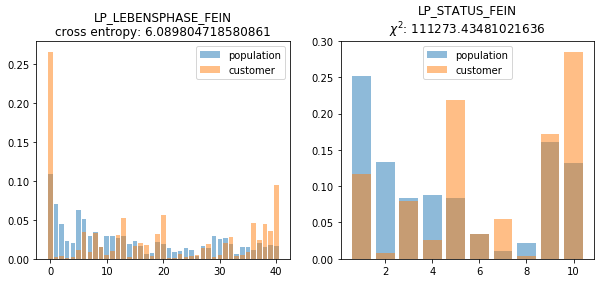

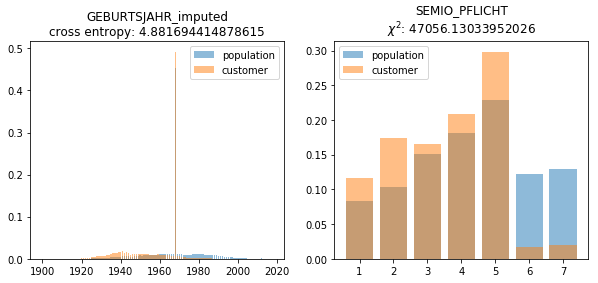

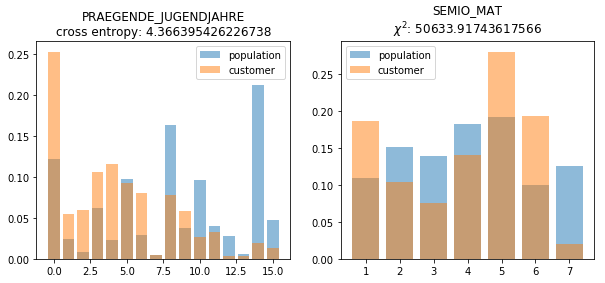

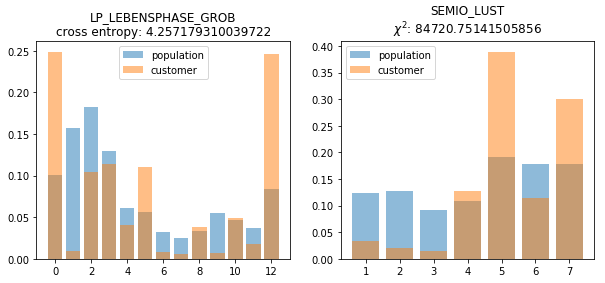

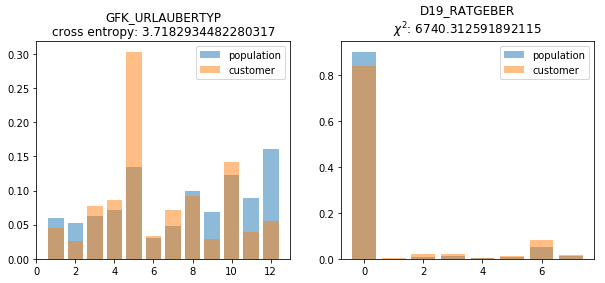

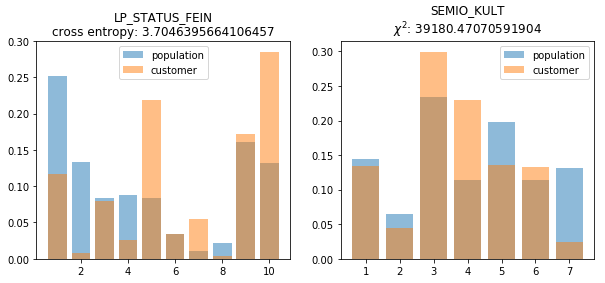

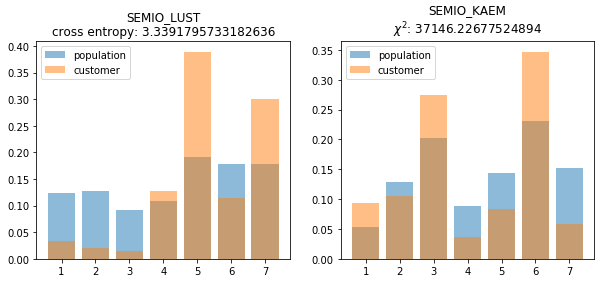

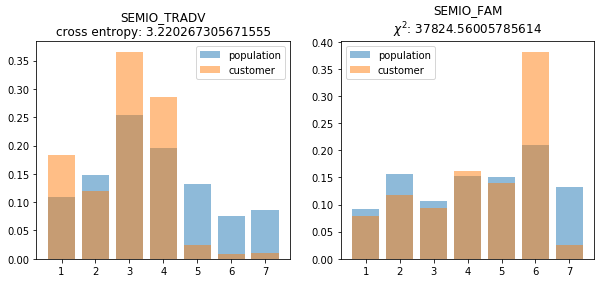

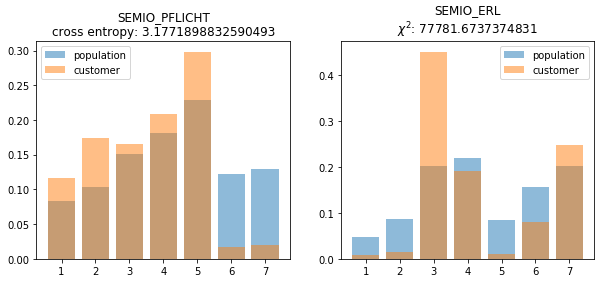

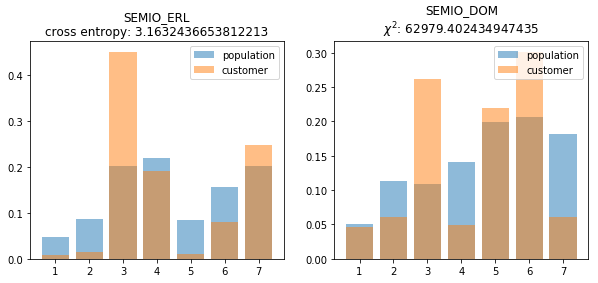

In [134]:
# plot the features with the highest x^2 test statistic
# between population and customer data 
n_plots = 10
def plot_dist(ax, x, y1, y2, title):
    ax.bar(x, y1, label='population', alpha=.5)
    ax.bar(x, y2, label='customer', alpha=.5)
    ax.legend()
    ax.set_title(title)

for idx_ce, idx_x2 in zip(max_diff_ce[:n_plots], max_diff_x2[:n_plots]):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
    col_ce = keep_columns.index[idx_ce]
    col_x2 = keep_columns.index[idx_x2]
    plot_dist(ax1, cats[idx_ce], 
              probs[idx_ce][0,:], probs[idx_ce][1,:],
              col_ce+'\ncross entropy: {}'.format(cross_entropy[idx_ce]))
    plot_dist(ax2, cats[idx_x2], 
              probs[idx_x2][0,:], probs[idx_x2][1,:],
              col_x2+'\n$\chi^2$: {}'.format(x2[idx_x2]))
    plt.show()

In the plots above, we can see which features have the most different distributions between the general population and the customers. In theory, keeping a subset of these discriminative variables will aid in segmenting the customers from the population. Interestingly, the $\chi^2$ test indicates that all of the features are signficant so it is not very useful.

However, manual inspection of these plots yields some interesting insights:

Now, let's get back to clustering. First, I'll convert the birth year to a categorical variable by binning it into decades. Then I'll apply k-modes to the data. k-Modes is like k-means but is more appropriate for categorical data.

In [146]:
cust_tmp = cust_t_red_imp.drop(['GEBURTSJAHR_imputed'], axis=1)
pop_tmp = pop_t_red_imp.drop(['GEBURTSJAHR_imputed'], axis=1)
birth_years = np.hstack((cust_t_red_imp['GEBURTSJAHR_imputed'].values,
                         pop_t_red_imp['GEBURTSJAHR_imputed'].values))

binned_births = pd.cut(birth_years, 5, labels=False)
idx = len(cust_tmp)
cust_data = np.hstack((cust_tmp.values, binned_births[:idx].reshape((-1,1))))
pop_data = np.hstack((pop_tmp.values, binned_births[idx:].reshape((-1,1))))

In [148]:
!pip install kmodes

from kmodes.kmodes import KModes
km = KModes(n_clusters=5, init='Huang', n_init=1, verbose=2)
km.fit(pop_data)

# Print the cluster centroids
#print(km.cluster_centroids_)

KeyboardInterrupt: 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [116]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [147]:
columns_reduced = [n for n in target_corr_names if n not in ['label', 'GEBURTSJAHR_imputed', 'has_birth_year']] #k_modes_features # + ['GEBURTSJAHR']
mailout_train_reduced = mailout_train[columns_reduced].copy()
y = mailout_train['RESPONSE'].copy()

#### augment #####
aug = cust_t_red_imp[columns_reduced].copy()
y = np.hstack((y.values, np.ones(len(aug))))
aug = pd.concat((mailout_train_reduced, aug), axis=0)

mailout_train_reduced.head()

,D19_KONSUMTYP_MAX,LP_LEBENSPHASE_FEIN,CJT_TYP_5,CJT_TYP_6,LP_LEBENSPHASE_GROB,CJT_TYP_3,LP_STATUS_FEIN,CJT_TYP_4,KOMBIALTER,HH_EINKOMMEN_SCORE,...,D19_VERSI_ANZ_24,D19_TIERARTIKEL,D19_TELKO_ANZ_24,D19_VERSI_ANZ_12,D19_BANKEN_REST,D19_BANKEN_LOKAL,D19_TELKO_ANZ_12,D19_DIGIT_SERV,D19_VERSI_ONLINE_DATUM,D19_TELKO_ONLINE_DATUM
0,2,8.0,5.0,5.0,2.0,5.0,3.0,5.0,4,6.0,...,0,0,0,0,0,0,0,0,10,10
1,4,19.0,5.0,4.0,5.0,4.0,9.0,3.0,4,1.0,...,0,6,1,0,0,3,1,0,10,10
2,2,0.0,5.0,5.0,0.0,5.0,10.0,5.0,4,1.0,...,0,0,0,0,5,0,0,0,10,10
3,2,16.0,5.0,4.0,4.0,5.0,3.0,5.0,4,4.0,...,0,0,0,0,0,0,0,0,10,10
4,2,9.0,5.0,5.0,3.0,5.0,6.0,5.0,4,4.0,...,0,0,0,0,0,0,0,0,10,10


In [126]:
print(len(y)-np.sum(y))
print(np.sum(y))

42430.0
188971.0


In [111]:
!pip install xgboost

    100% |████████████████████████████████| 109.8MB 232kB/s eta 0:00:01 7% |██▌                             | 8.7MB 32.1MB/s eta 0:00:04    19% |██████                          | 20.9MB 30.7MB/s eta 0:00:03    31% |██████████▏                     | 34.9MB 27.6MB/s eta 0:00:03    36% |███████████▊                    | 40.1MB 25.5MB/s eta 0:00:03    37% |████████████                    | 41.2MB 25.2MB/s eta 0:00:03    38% |████████████▍                   | 42.4MB 26.4MB/s eta 0:00:03    39% |████████████▊                   | 43.7MB 26.0MB/s eta 0:00:03    40% |█████████████                   | 45.0MB 26.3MB/s eta 0:00:03    42% |█████████████▌                  | 46.2MB 26.1MB/s eta 0:00:03    46% |██████████████▉                 | 51.0MB 25.6MB/s eta 0:00:03    51% |████████████████▌               | 56.8MB 21.8MB/s eta 0:00:03    57% |██████████████████▎             | 62.7MB 24.6MB/s eta 0:00:02    59% |███████████████████             | 65.1MB 23.5MB/s eta 0:00:02    61% |███████████████

In [148]:
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import XGBClassifier as GBC
from sklearn.model_selection import GridSearchCV as GSCV
weight = 42430/188971.0
weights = np.ones(len(y))
weights[y==1] = weight

#param_grid = {'max_depth':[25],
#              'max_features':[None, 'sqrt'],
#              'min_samples_leaf':[1,5],
#              'n_estimators': [100]}
#grid_search = GSCV(RFC(class_weight='balanced_subsample'), 
#                   param_grid, scoring='roc_auc',
#                   verbose=2, cv=5, n_jobs=-1, 
#                   )

param_grid = {'max_depth':[3,6],
              'colsample_bynode': [1],
              'alpha': [1]}
grid_search = GSCV(GBC(scale_pos_weight=weight,
                       verbosity=1), 
                  param_grid, scoring='roc_auc',
                  verbose=2, cv=5, n_jobs=-1, 
                  )

grid_search.fit(aug, y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] alpha=1, colsample_bynode=1, max_depth=3 ........................
[CV] ......... alpha=1, colsample_bynode=1, max_depth=3, total= 1.2min
[CV] alpha=1, colsample_bynode=1, max_depth=3 ........................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ......... alpha=1, colsample_bynode=1, max_depth=3, total= 1.2min
[CV] alpha=1, colsample_bynode=1, max_depth=3 ........................
[CV] ......... alpha=1, colsample_bynode=1, max_depth=3, total= 1.2min
[CV] alpha=1, colsample_bynode=1, max_depth=3 ........................
[CV] ......... alpha=1, colsample_bynode=1, max_depth=3, total= 1.2min
[CV] alpha=1, colsample_bynode=1, max_depth=3 ........................
[CV] ......... alpha=1, colsample_bynode=1, max_depth=3, total= 1.2min
[CV] alpha=1, colsample_bynode=1, max_depth=6 ........................
[CV] ......... alpha=1, colsample_bynode=1, max_depth=6, total= 2.2min
[CV] alpha=1, colsample_bynode=1, max_depth=6 ........................
[CV] ......... alpha=1, colsample_bynode=1, max_depth=6, total= 2.2min
[CV] alpha=1, colsample_bynode=1, max_depth=6 ........................
[CV] ......... alpha=1, colsample_bynode=1, max_depth=6, total= 2.2min
[CV] alpha=1, colsample_bynode=1, max_depth=6 ........................
[CV] .

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 17.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w...80646765905,
       subsample=None, tree_method=None, validate_parameters=False,
       verbosity=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 6], 'colsample_bynode': [1], 'alpha': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [149]:
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_estimator_)
train_preds = grid_search.predict_proba(aug)[:,1]

[ 0.75363452  0.75208028]
XGBClassifier(alpha=1, base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=1,
       reg_lambda=1, scale_pos_weight=0.22453180646765905, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=1)


In [150]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y, train_preds, sample_weight=weights))

0.764130079252


In [159]:
nb.fit(aug.values, y)
pred_score = nb.predict_proba(aug.values)[:,1]
print(roc_auc_score(y, pred_score, sample_weight=weights))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [160]:
np.isfinite(aug.values).all()

False

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [151]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [152]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [153]:
mailout_test_reduced = mailout_test[columns_reduced].copy()
mailout_test_reduced.index = mailout_test['LNR']
mailout_test_reduced.head()

,D19_KONSUMTYP_MAX,LP_LEBENSPHASE_FEIN,CJT_TYP_5,CJT_TYP_6,LP_LEBENSPHASE_GROB,CJT_TYP_3,LP_STATUS_FEIN,CJT_TYP_4,KOMBIALTER,HH_EINKOMMEN_SCORE,...,D19_VERSI_ANZ_24,D19_TIERARTIKEL,D19_TELKO_ANZ_24,D19_VERSI_ANZ_12,D19_BANKEN_REST,D19_BANKEN_LOKAL,D19_TELKO_ANZ_12,D19_DIGIT_SERV,D19_VERSI_ONLINE_DATUM,D19_TELKO_ONLINE_DATUM
LNR,,,,,,,,,,,,,,,,,,,,,
1754,2,20.0,5.0,5.0,5.0,5.0,10.0,5.0,4,4.0,...,0,0,0,0,0,0,0,0,10,10
1770,2,6.0,4.0,5.0,2.0,5.0,1.0,5.0,4,5.0,...,0,0,0,0,0,0,0,0,10,10
1465,8,40.0,5.0,5.0,12.0,5.0,10.0,5.0,4,5.0,...,0,0,0,0,0,0,0,0,10,10
1470,8,0.0,5.0,5.0,0.0,5.0,3.0,5.0,4,3.0,...,0,0,0,0,0,0,0,0,10,10
1478,1,37.0,4.0,3.0,12.0,4.0,9.0,4.0,4,4.0,...,1,7,1,0,6,0,0,0,9,9


In [154]:
test_preds = grid_search.predict_proba(mailout_test_reduced)[:,1]

In [155]:
test_preds

array([ 0.77163678,  0.48192078,  0.14121535, ...,  0.58492297,
        0.54257309,  0.59884381], dtype=float32)

In [156]:
results = pd.DataFrame(np.vstack((mailout_test_reduced.index, test_preds)).T,
                       columns=['LNR', 'RESPONSE'])
results['LNR'] = results['LNR'].astype(int)
results.head()

,LNR,RESPONSE
0,1754,0.771637
1,1770,0.481921
2,1465,0.141215
3,1470,0.069507
4,1478,0.219488


In [157]:
results.to_csv("./submission_xgb_aug_full.csv", index=False)